# ES335 Assignment 1: Task 1

In this part of the Assignment, we mainly preprocess the data and then perform some exploratory data analysis on the data. After that we answer the following questions:

1. **Plot the waveform** for one sample data from each activity class.  
   Are you able to see any difference/similarities between the activities?  
   You can plot a subplot having 6 columns to show differences/similarities between the activities.  
   Do you think the model will be able to classify the activities based on the data?  
   **[0.5 marks]**

2. Do you think we need a machine learning model to differentiate between static activities (laying, sitting, standing) and dynamic activities (walking, walking_downstairs, walking_upstairs)?  
   Look at the linear acceleration  
   \[
   acc_x^2 + acc_y^2 + acc_z^2
   \]  
   for each activity and justify your answer.  
   **[0.5 marks]**

3. **Visualize the data using PCA. [1 marks]**
   - Use PCA (Principal Component Analysis) on Total Acceleration  
     \[
     acc_x^2 + acc_y^2 + acc_z^2
     \]  
     to compress the acceleration timeseries into two features and plot a scatter plot to visualize different class of activities.
   - Next, use **TSFEL (a featurizer library)** to create features (your choice which ones you feel are useful) and then perform PCA to obtain two features. Plot a scatter plot to visualize different class of activities.
   - Now use the features provided by the dataset and perform PCA to obtain two features. Plot a scatter plot to visualize different class of activities.
   - Compare the results of PCA on Total Acceleration, TSFEL and the dataset features. Which method do you think is better for visualizing the data?

4. **Calculate the correlation matrix** of the features obtained by TSFEL and provided in the dataset.  
   Identify the features that are highly correlated with each other. Are there any redundant features?  
   **[1 marks]**


**Imports**

In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np
import random
import seaborn as sns
from GenerateDataset import generate_dataset

**Utility Functions**

In [2]:
activity_classes = ["LAYING", "SITTING", "STANDING", "WALKING", "WALKING_DOWNSTAIRS", "WALKING_UPSTAIRS"]

def get_sample_data(path, files_per_activity=-1):
    sample_data = []
    for activity_class in activity_classes:
        subpath = os.path.join(path, activity_class)
        files = os.listdir(subpath)
        num_files = len(files) if files_per_activity == -1 else files_per_activity
        for file in range(num_files):
            sample_data.append(os.path.join(subpath, files[file]))
    return sample_data

def load_csv_files(directory, label, add_timestamp=True, add_total_acc=True, trim_data=True):
    df_list = []
    for filename in os.listdir(directory):
        if filename.endswith('.csv'):
            file_path = os.path.join(directory, filename)
            df = pd.read_csv(file_path)
            df['subject'] = filename.replace('.csv', '')
            # 50 samples per second
            # 1 sample takes 1/50 seconds
            if add_timestamp:
                df['timestamp'] = (df.index + 1) / 50
            if add_total_acc:
                df['total_acc'] = df['accx'] ** 2 + df['accy'] ** 2 + df['accz'] ** 2
            if trim_data:
                df_list.append(df.iloc[100:600, :])
            else:
                df_list.append(df)
    combined_df = pd.concat(df_list, ignore_index=True)
    combined_df['y'] = label
    return combined_df

def prepare_dataset(path):
    train_path = os.path.join(path, "Train")
    test_path = os.path.join(path, "Test")
    
    train_dfs = pd.concat([load_csv_files(os.path.join(train_path, activity_class), label) for label, activity_class in enumerate(activity_classes)])
    test_dfs = pd.concat([load_csv_files(os.path.join(test_path, activity_class), label) for label, activity_class in enumerate(activity_classes)])
    
    return train_dfs, test_dfs

def get_tsfel_features(tsfel_features_path):   
    data = pd.DataFrame()
    for label, activity_class in enumerate(activity_classes):
        folder_path = os.path.join(tsfel_features_path, activity_class)
        dfs = load_csv_files(folder_path, label, False, False, False)
        data = pd.concat([data, dfs], axis=0, ignore_index=True)
    return data

def plot_pca(x: np.ndarray, y: np.ndarray, components=2, dot_size=0.5, title="PCA Scatter Plot"):
    scaler = StandardScaler()
    x_normalized = scaler.fit_transform(x)
    pca = PCA(n_components=components)
    x_pca = pca.fit_transform(x_normalized)

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(x_pca[:, 0], x_pca[:, 1], c=y, cmap='viridis', s=dot_size)
    plt.gca().add_artist(plt.legend(*scatter.legend_elements(), loc="upper right", title="Labels"))
    plt.xlabel(f'First Principal Component')
    plt.ylabel(f'Second Principal Component')
    plt.title(title)
    plt.show()

# Solutions  

## 1. Plot the waveform for one sample data from each activity class.  

After loading the data, we plot the waveform for one sample data from each activity class, we can see that there is a clear distinction between the static and dynamic activities. For the static activities, we can see that the orientation of the phone is different for standing, sitting, and laying. For the dynamic activities, we can see that the amplitude and the waveform for each of the classes is different. Hence, the model should be able to classify the activities based on the data.


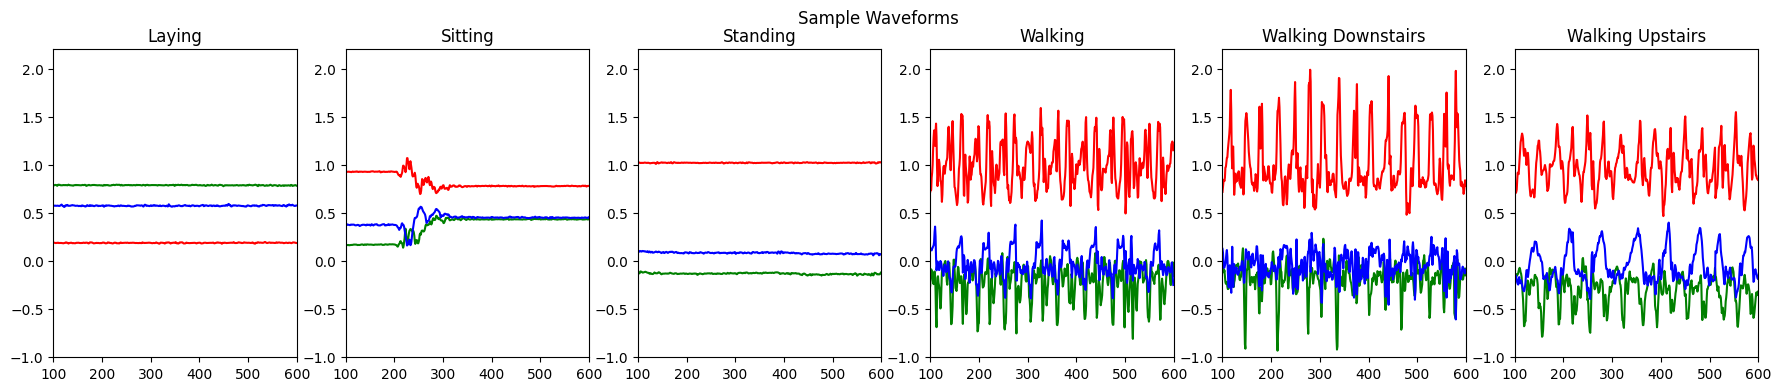

In [3]:
sample_data = get_sample_data(os.path.join('Datasets','Combined', 'Train'), 1)
titles = [sample.split('\\')[3].title().replace('_', ' ') for sample in sample_data]

def plot_waveforms():
    fig, (ax1, ax2,ax3,ax4,ax5,ax6) = plt.subplots(1, 6, figsize=(22, 4))
    fig.suptitle('Sample Waveforms')

    dfs = [pd.read_csv(sample_data[i]).iloc[100:600,:] for i in range(6)]
    for i, ax in enumerate((ax1, ax2, ax3, ax4, ax5, ax6)):
        ax.set_title(titles[i])
        ax.set_ylim([-1, 2.2])
        ax.set_xlim([100, 600])
        ax.plot(dfs[i]['accx'], color='r')
        ax.plot(dfs[i]['accy'], color='g')
        ax.plot(dfs[i]['accz'], color='b')

plot_waveforms()

## 2. Do you think we need a machine learning model to differentiate between static activities and dynamic activities?
If we look at the plots of the static and dynamic activities, we can see that the plots for the static and dynamic activities are more or less constant compared to the dynamic activities. So in this case, we can use a simple variance threshold to distinguish between a static activity and dynamic activity. Hence we do not need a machine learning model to differentiate between static and dynamic activities.

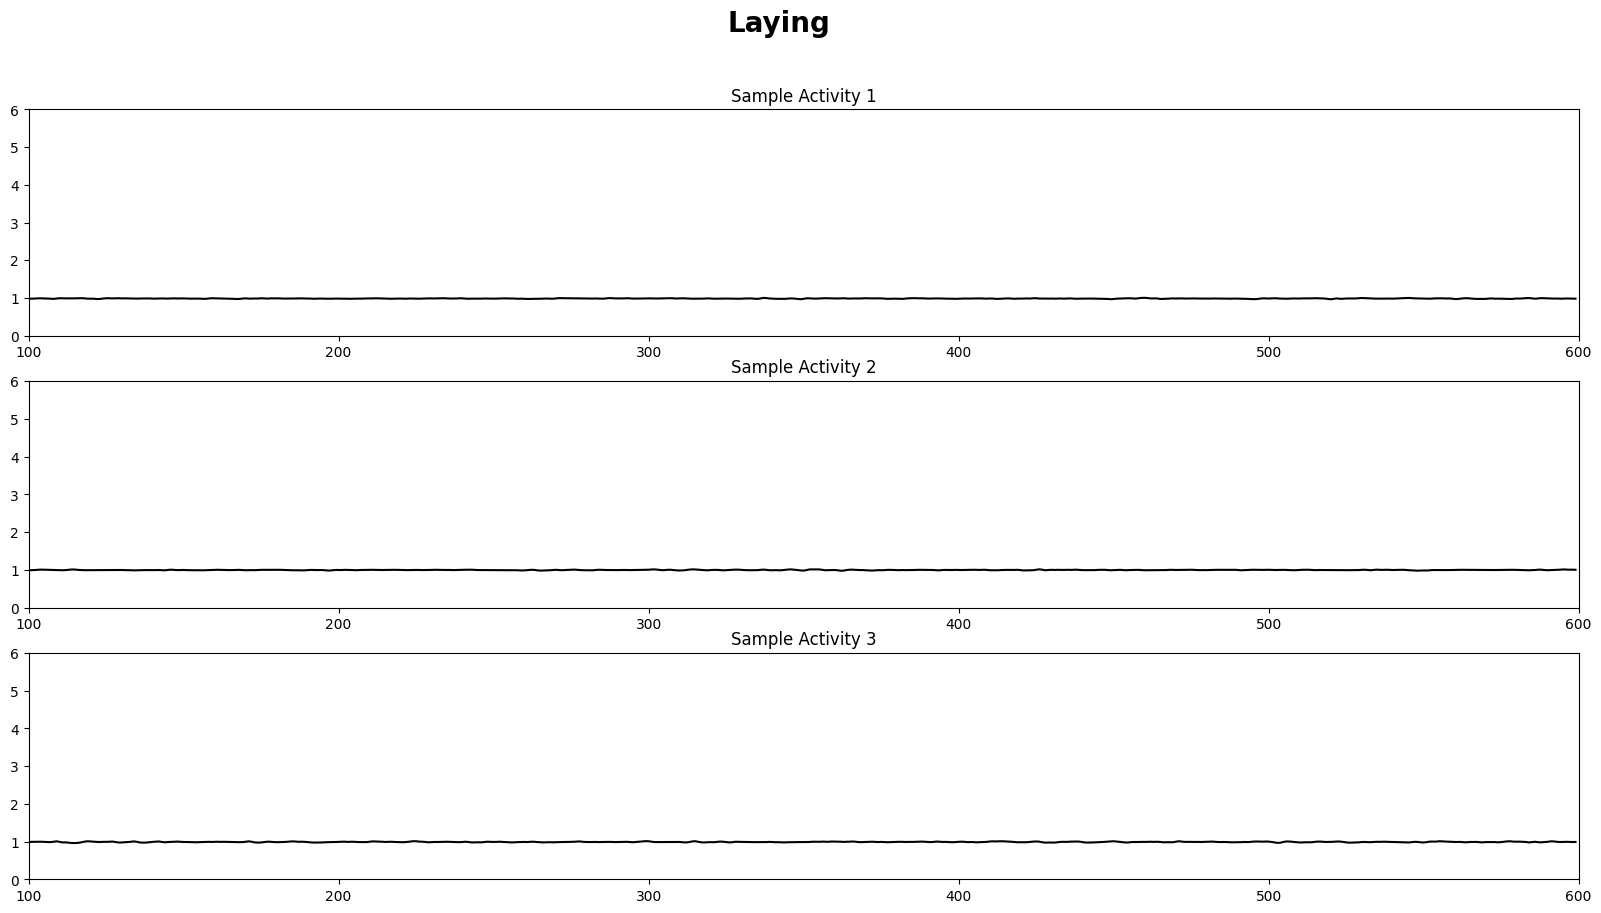

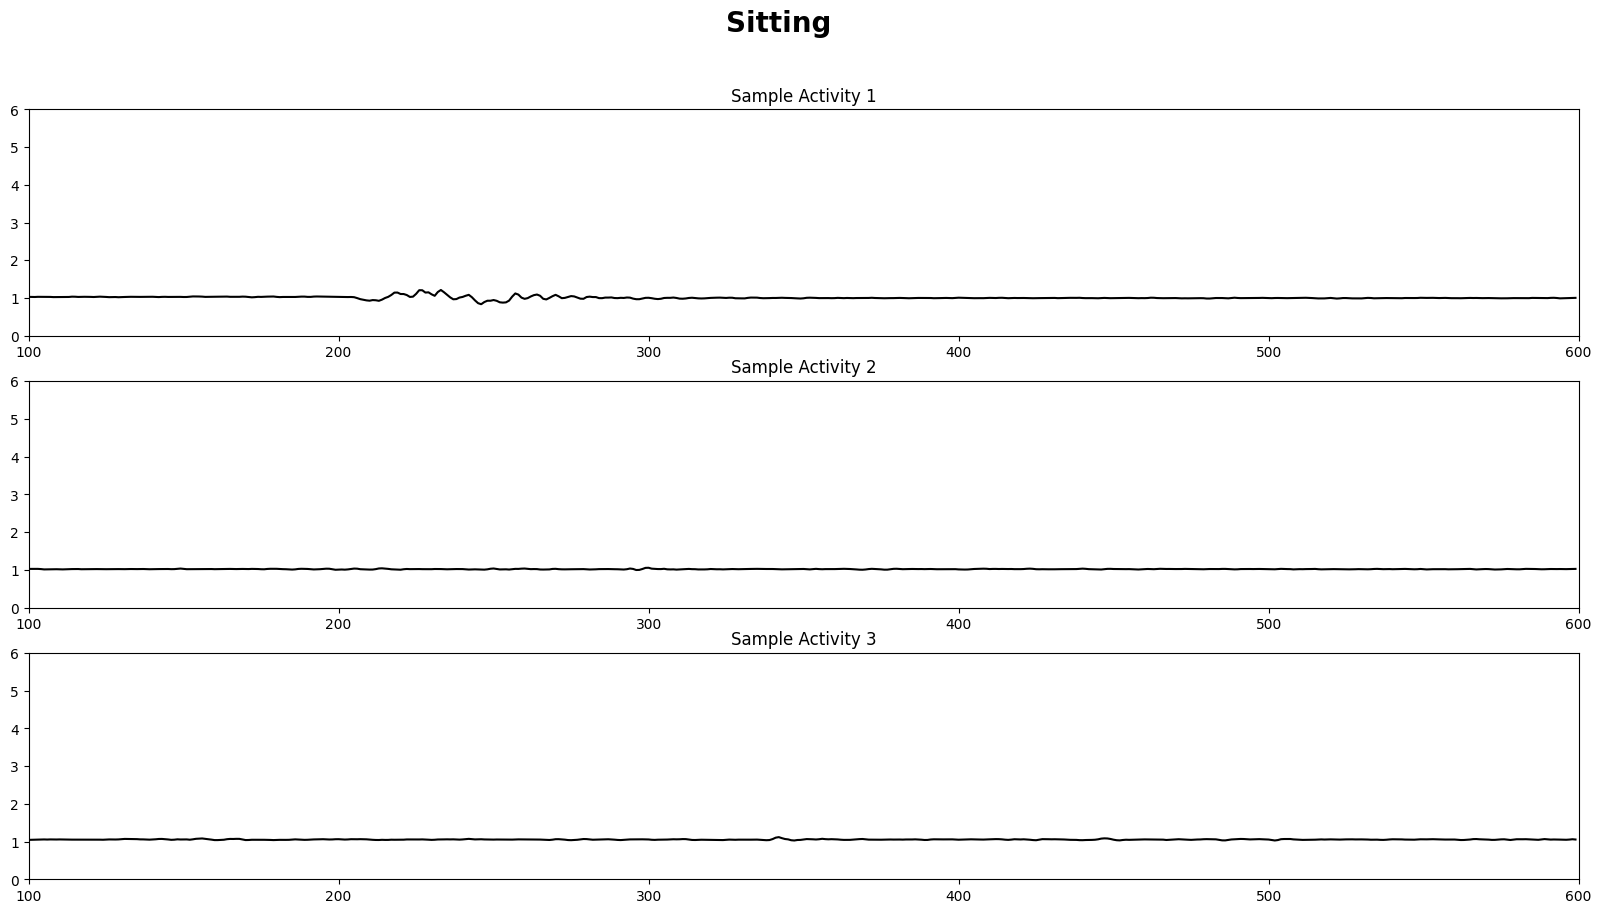

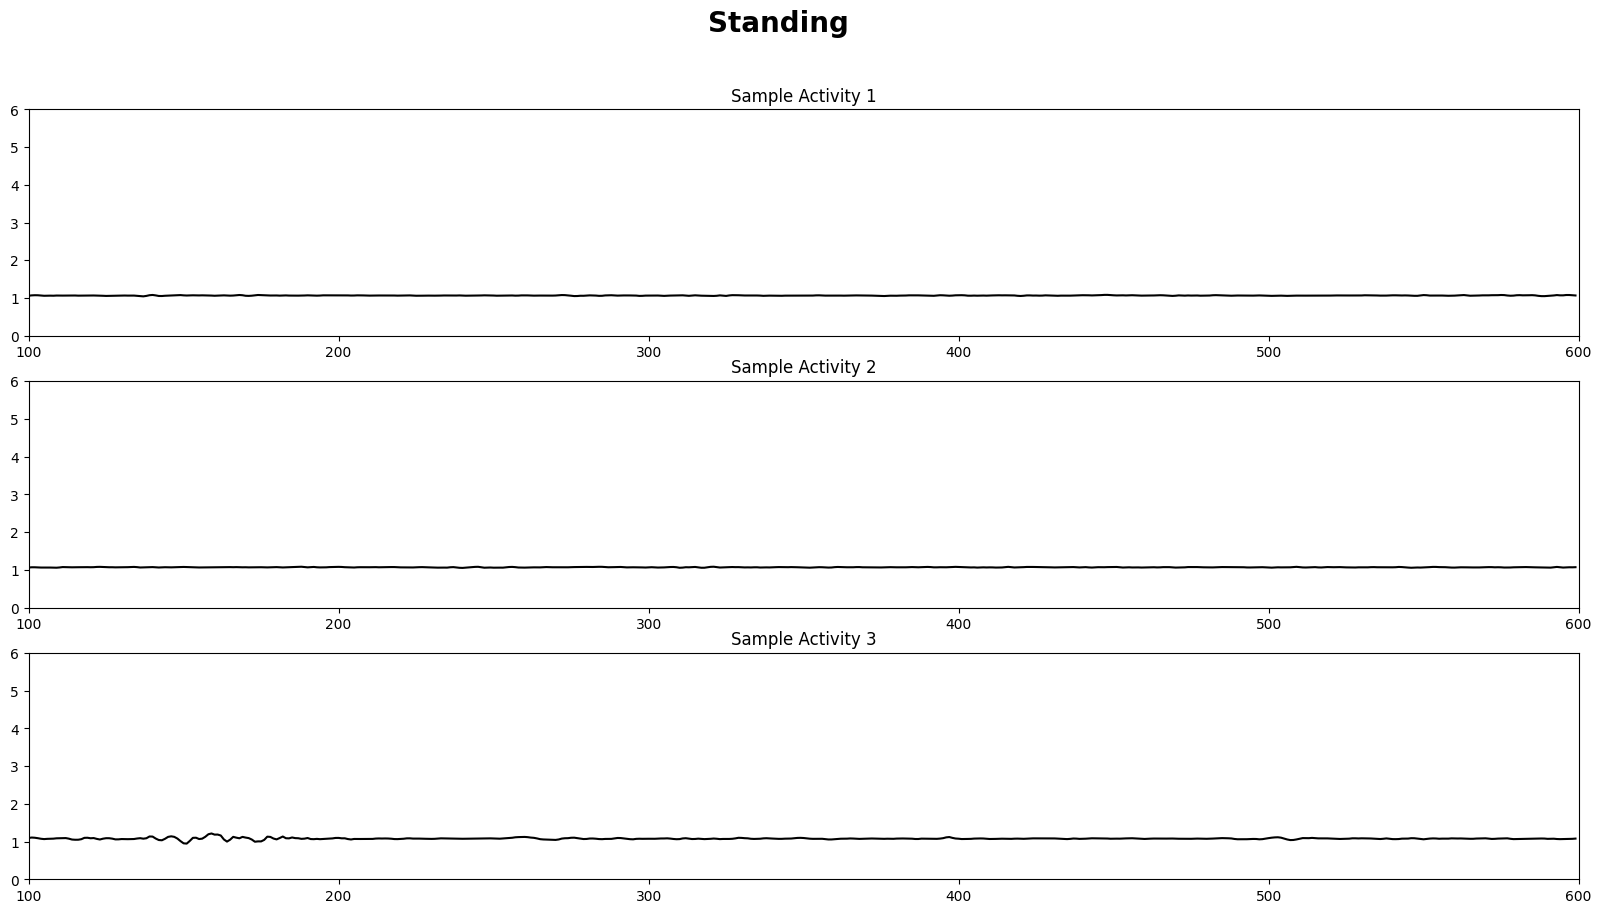

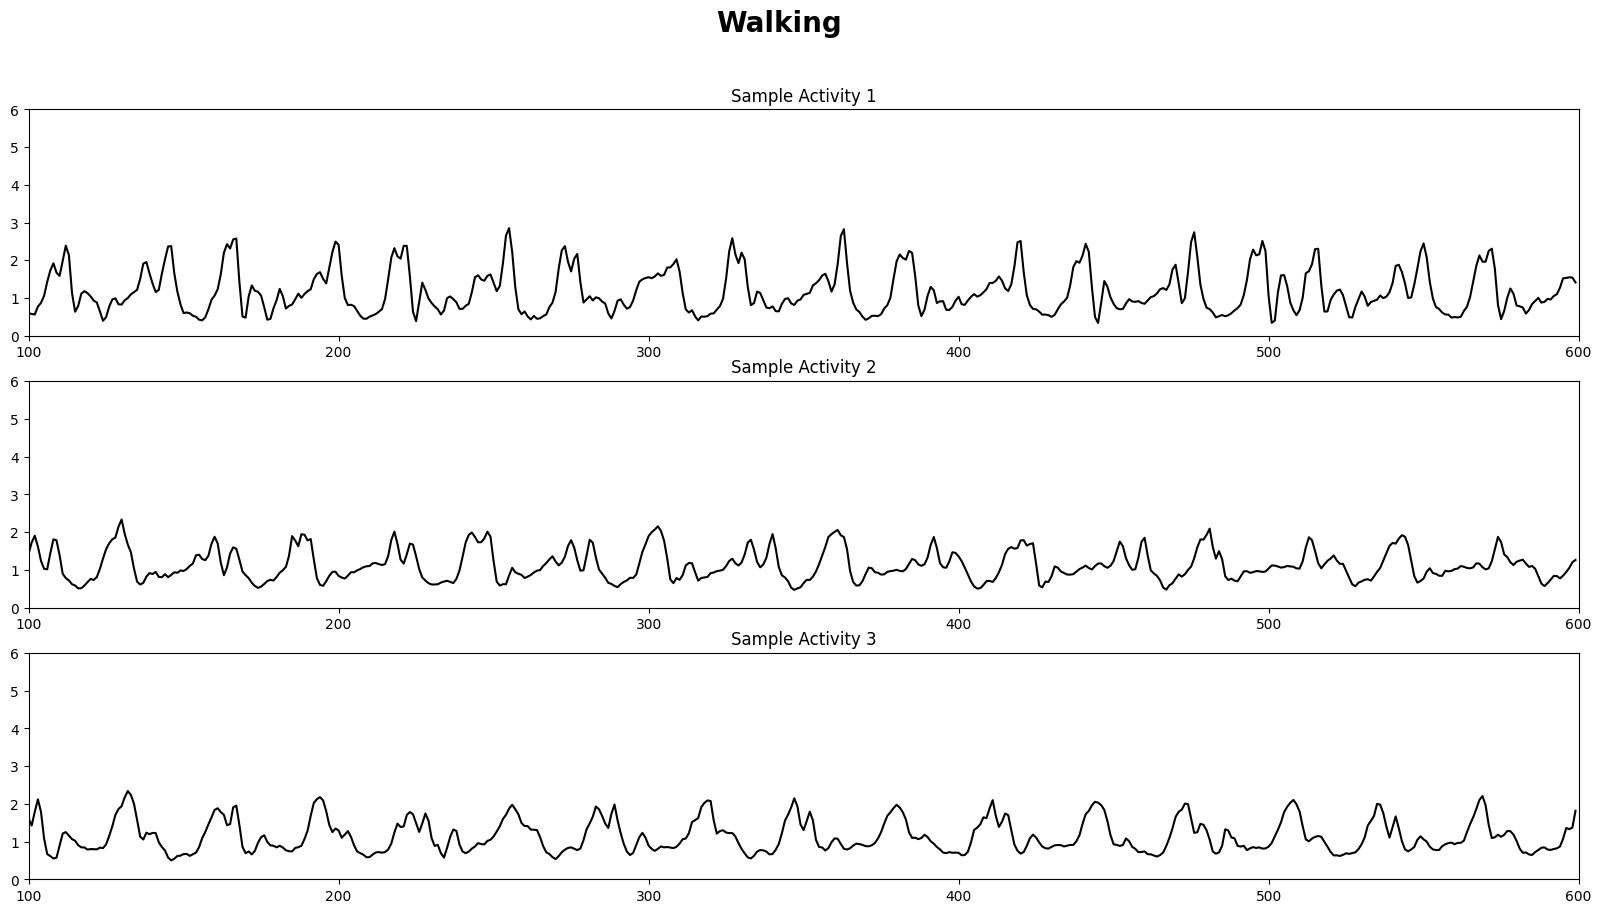

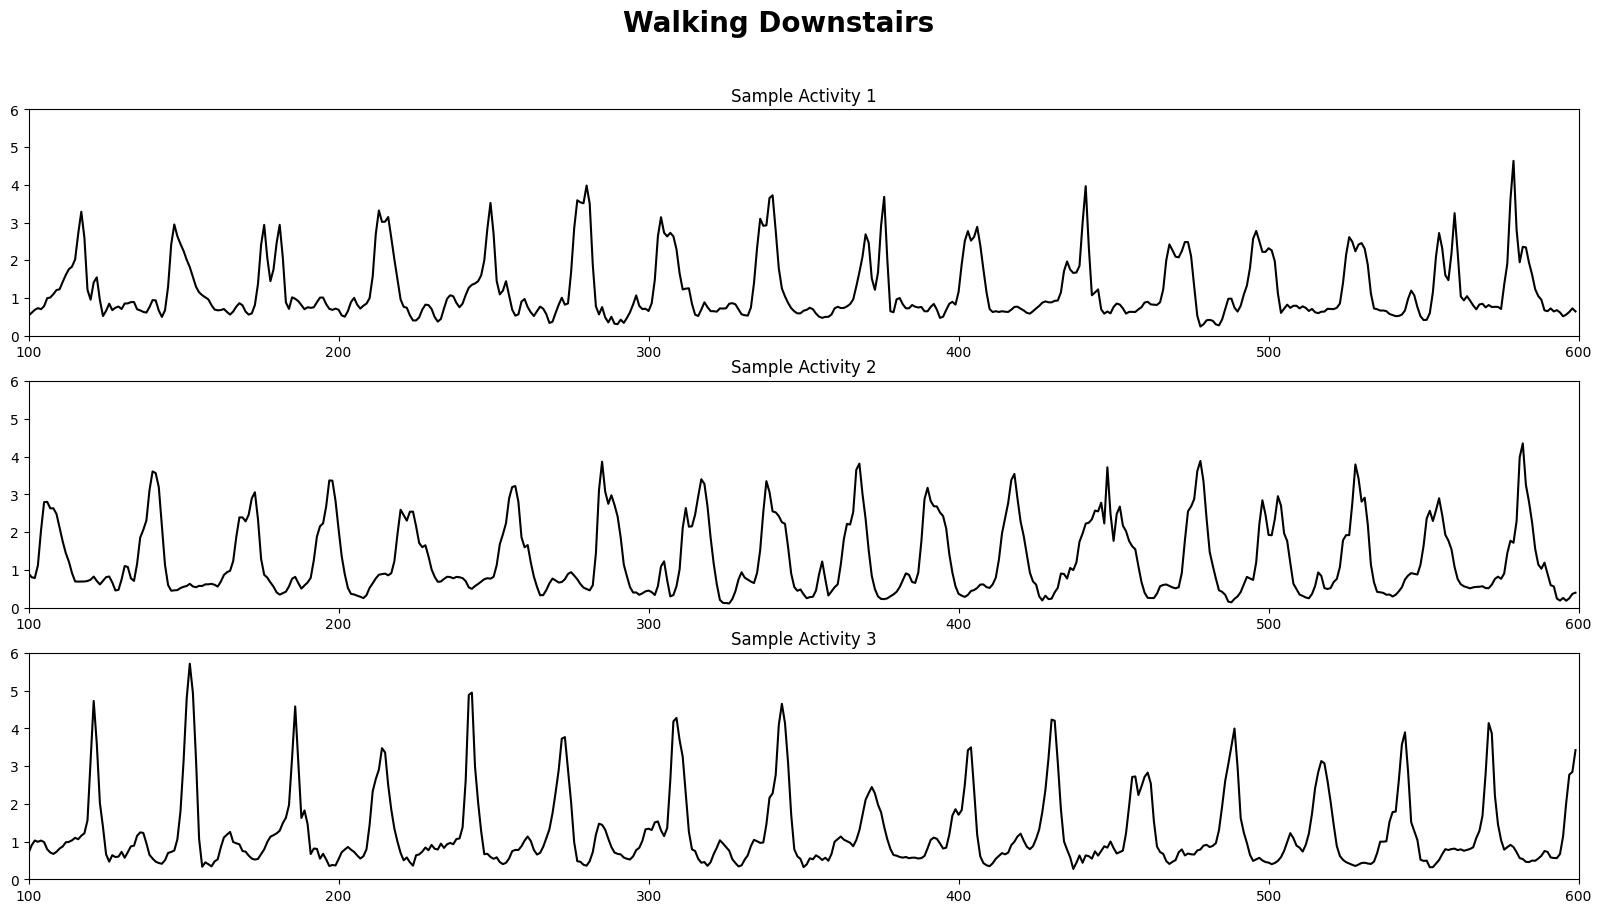

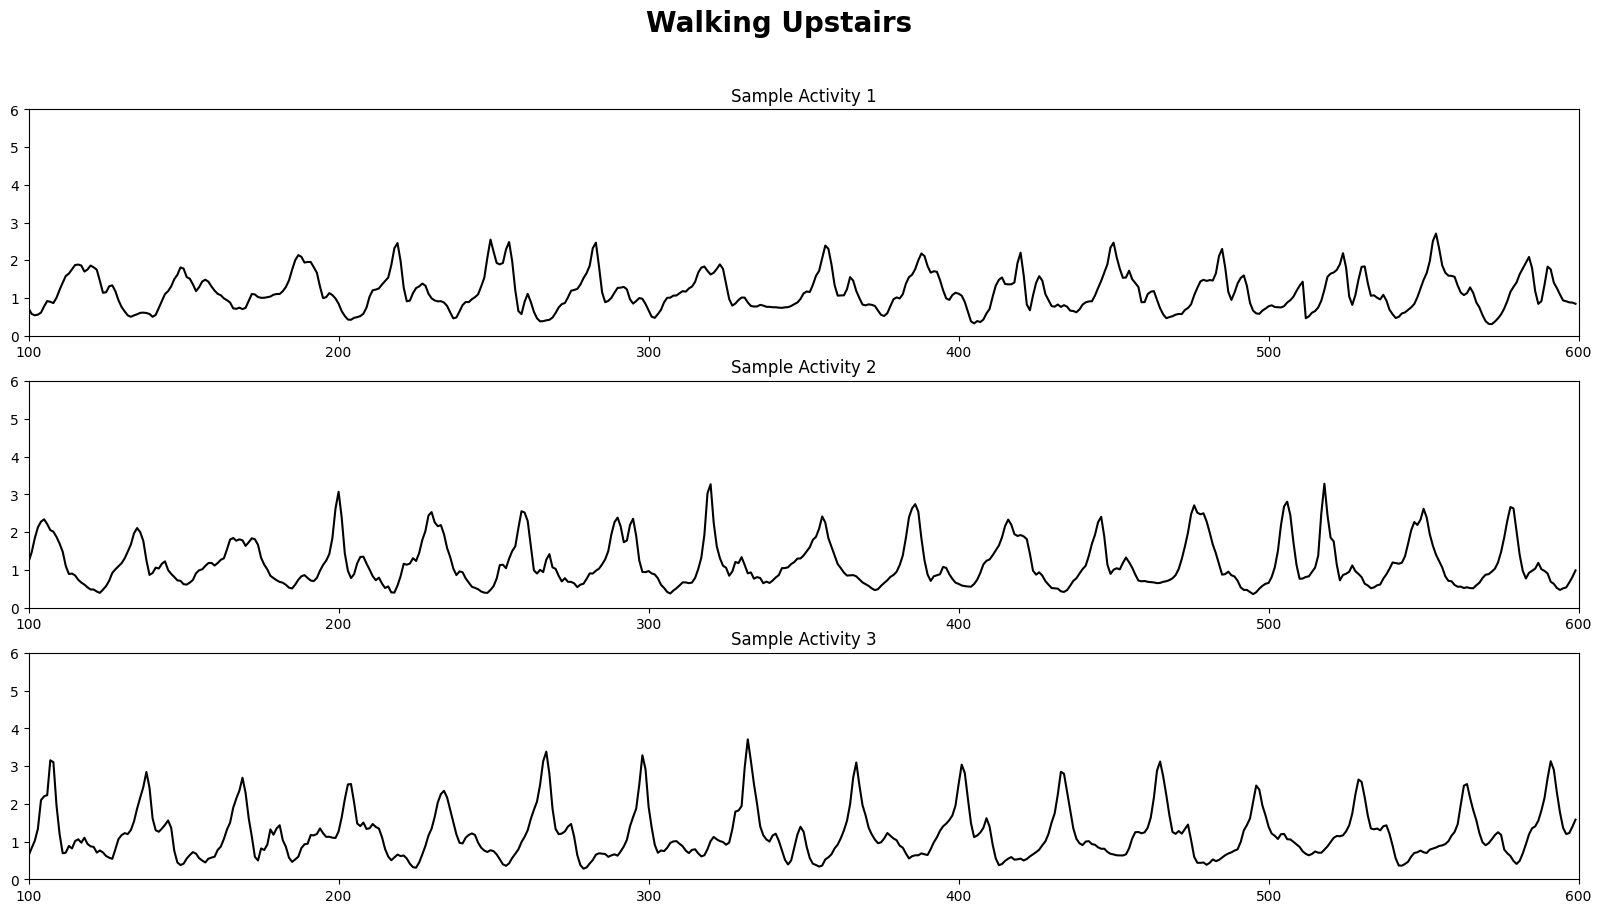

In [4]:
def plot_sample_activities():
    activity_sample_data = get_sample_data(os.path.join( 'Datasets','Combined', 'Train'), 3)

    dfs=[pd.read_csv(activity_sample_data[i]).iloc[100:600, :] for i in range(18)]

    linear_accelerations = [dfs[i]['accx'] * dfs[i]['accx'] + dfs[i]['accy'] * dfs[i]['accy'] + dfs[i]['accz'] * dfs[i]['accz'] for i in range(18)]
    fig, ax = [], []
    for i in range(6):
        fig_, ax_ = plt.subplots(3, 1, figsize=(20, 10))
        fig.append(fig_)
        ax.append(ax_)
    for i, (fig_, ax_) in enumerate(zip(fig, ax)):
        fig_.suptitle(titles[i], fontsize=20, fontweight='heavy')
        for j in range(3):
            ax_[j].set_title(f'Sample Activity {j + 1}')
            ax_[j].set_xlim([100, 600])
            ax_[j].set_ylim([0, 6])
            ax_[j].plot(linear_accelerations[3 * i + j], color='black')
plot_sample_activities()

In [5]:
train,test=prepare_dataset("Datasets\Combined")
vars=[]
for i in range(6):
    vars.append(train[train['y'] == i].groupby('subject')['total_acc'].var().mean().item())
print(f'Variance per activity: {vars}')

Variance per activity: [0.00017043717292130042, 0.00018399252454868873, 0.00022106129940491616, 0.2476351179609195, 0.876371113945597, 0.36179649334206393]


In [6]:
threshold=0.01 # this is a safe value seing the variance values from above
correct_samples = 0
for name, group in test.groupby(['subject', 'y']):
    if group['total_acc'].var().item() <= threshold:
        correct_samples += int(name[1] < 3)
    else:
        correct_samples += int(name[1] >= 3)
print("Accuracy in classifying static or dynamic activities:", correct_samples / test.groupby(['subject', 'y']).ngroups * 100, '%')

Accuracy in classifying static or dynamic activities: 100.0 %



## 3. Visualize the data using PCA.

In [7]:
train, test=prepare_dataset("Datasets\Combined")

## PCA (Principal Component Analysis) on Total Acceleration 
In this part, we use PCA on the total acceleration to compress the acceleration timeseries into two features and plot a scatter plot to visualize different classes of activities. We can see that the classes are not linearly separable, the data has the shape of (126, 500) which we reduce to (126, 2) using PCA. After that, we plot the PCA on on the accx, accy and accz and we can see that the classes turn out to be a bit more separable.

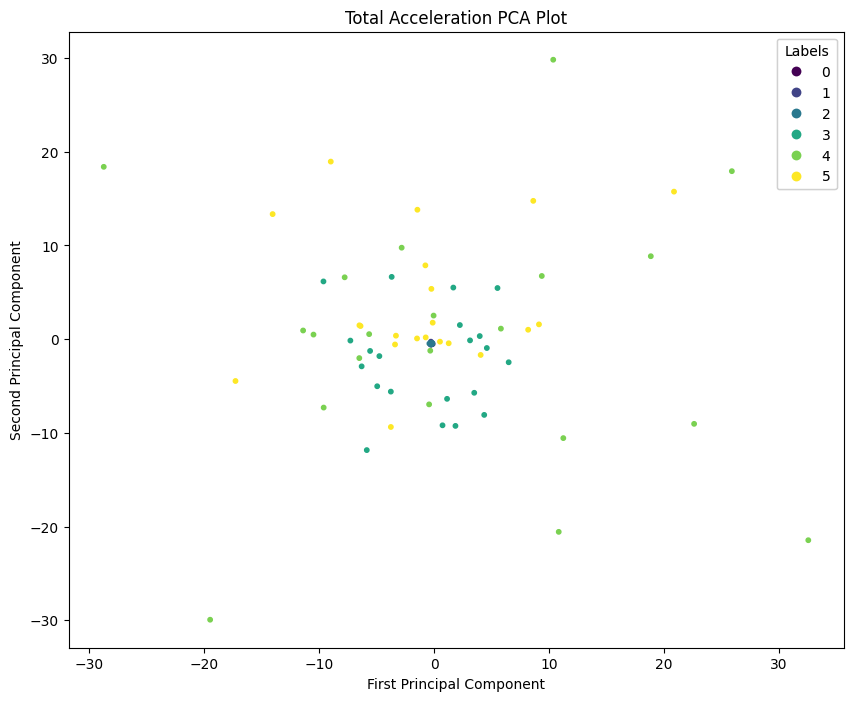

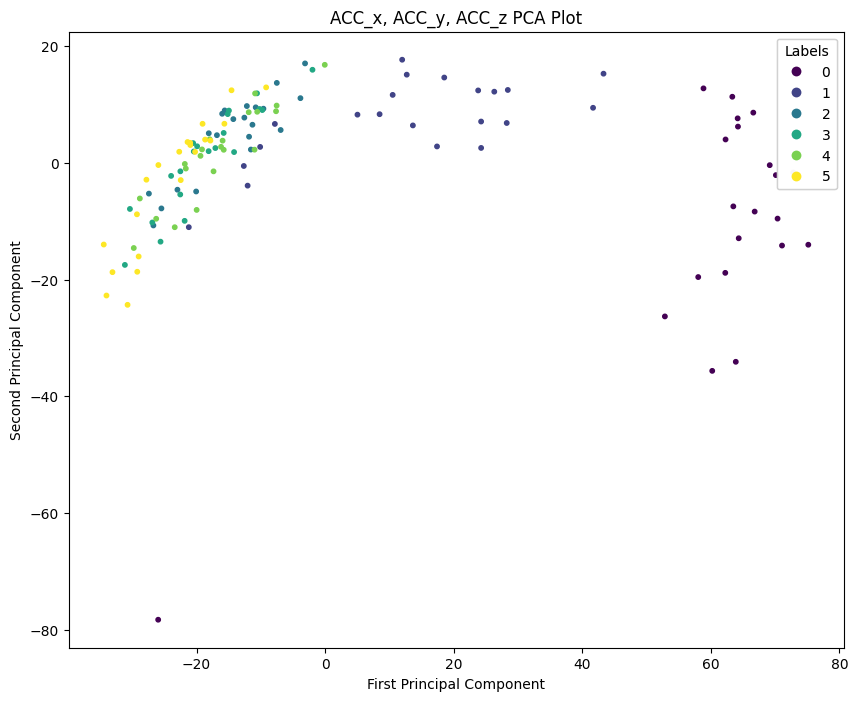

In [8]:
def plot_pca_total_acceleration_timeseries(dataset):
    data = dataset[['total_acc', 'y']].to_numpy().reshape(-1, 500, 2)
    x = data[:, :, 0]
    y = data[:, :, 1]
    y = y[:, 0]
    plot_pca(x, y, dot_size=10, title="Total Acceleration PCA Plot")

def plot_pca_acceleration_vector_timeseries(dataset):
    x = dataset[['accx', 'accy', 'accz']].to_numpy().reshape(-1, 500 * 3)
    y = dataset['y'].to_numpy().reshape(-1, 500)
    y = y[:, 0]
    plot_pca(x, y, dot_size=10, title="ACC_x, ACC_y, ACC_z PCA Plot")
    
plot_pca_total_acceleration_timeseries(train)
plot_pca_acceleration_vector_timeseries(train)
# activity_classes = ["LAYING", "SITTING", "STANDING", "WALKING", "WALKING_DOWNSTAIRS", "WALKING_UPSTAIRS"]


## PCA on TSFEL features
Previously in Asst#1_generate-features.py, we generated the TSFEL features for the test and train dataset and save it in Datasets/tsfel_3axes_allfeatures. We end up getting 1134 features.

In this part, we enable all the tsfel features and then use PCA to reduce the data to (126, 2) and plot the scatter plot. We can see that the classes are more separable compared to the PCA on the total acceleration. This suggests that we might get better results using the TSFEL features in a decision tree.

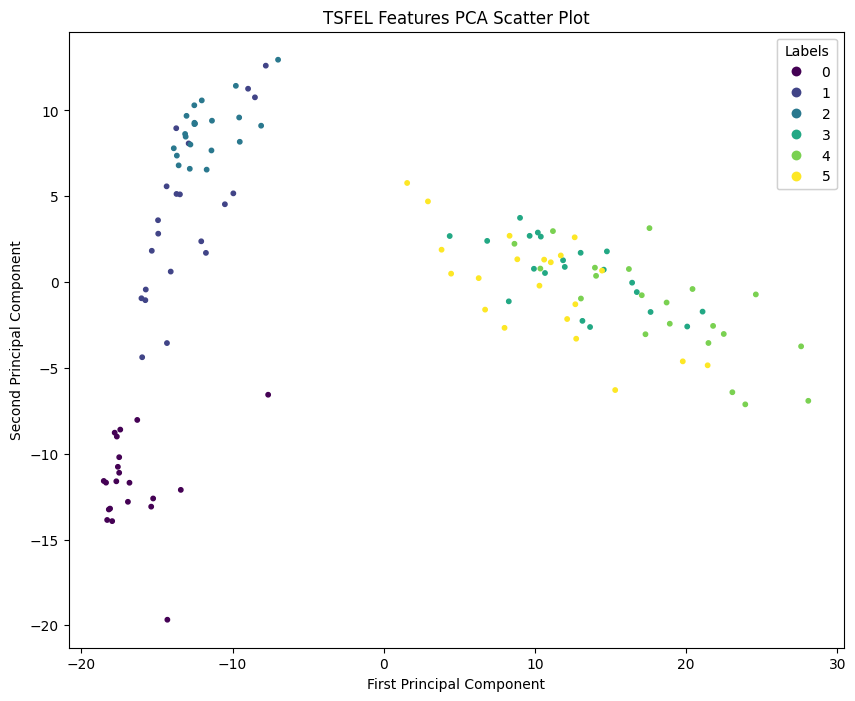

In [9]:
data = get_tsfel_features(r'Datasets/Combined/TSFEL_3axes_allfeatures/Train')

def plot_pca_tsfel(x: np.ndarray, y: np.ndarray, components=2):
    scaler = StandardScaler()
    x_normalized = scaler.fit_transform(x)
    pca = PCA(n_components=components)
    x_pca = pca.fit_transform(x_normalized)
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(x_pca[:, 0], x_pca[:, 1], c=y, cmap='viridis', s=10)
    plt.gca().add_artist(plt.legend(*scatter.legend_elements(), loc="upper right", title="Labels"))
    plt.xlabel(f'First Principal Component')
    plt.ylabel(f'Second Principal Component')
    plt.title('TSFEL Features PCA Scatter Plot')
    plt.show()

    components_df = pd.DataFrame(pca.components_, columns=data.columns[:-2], index=[f'PC{i+1}' for i in range(components)])
    return components_df.T

def plot_pca_acceleration_tsfel(data: pd.DataFrame):
    x = data[data.columns[:-2]].to_numpy()
    y = data['y'].to_numpy()
    return plot_pca_tsfel(x, y, 2)

loadings = plot_pca_acceleration_tsfel(data)
PC1, PC2 = loadings['PC1'], loadings['PC2']
PC1 = PC1.sort_values()
PC2 = PC2.sort_values()

# features = tsfel.time_series_features_extractor(cfg, df, fs=50)
# print(features.shape)



## PCA on UCI HAR dataset features
In this case, we take the 561 features that are provided in the UCI HAR dataset and use PCA to reduce the data to (126, 2) and plot the scatter plot. We can see that the classes are more separable compared to the PCA on the total acceleration. This suggests that we might get better results using the UCI HAR dataset features in a decision tree.

X_train: (7352, 561) X_test: (2947, 561)
y_train: (7352,) y_test: (2947,)


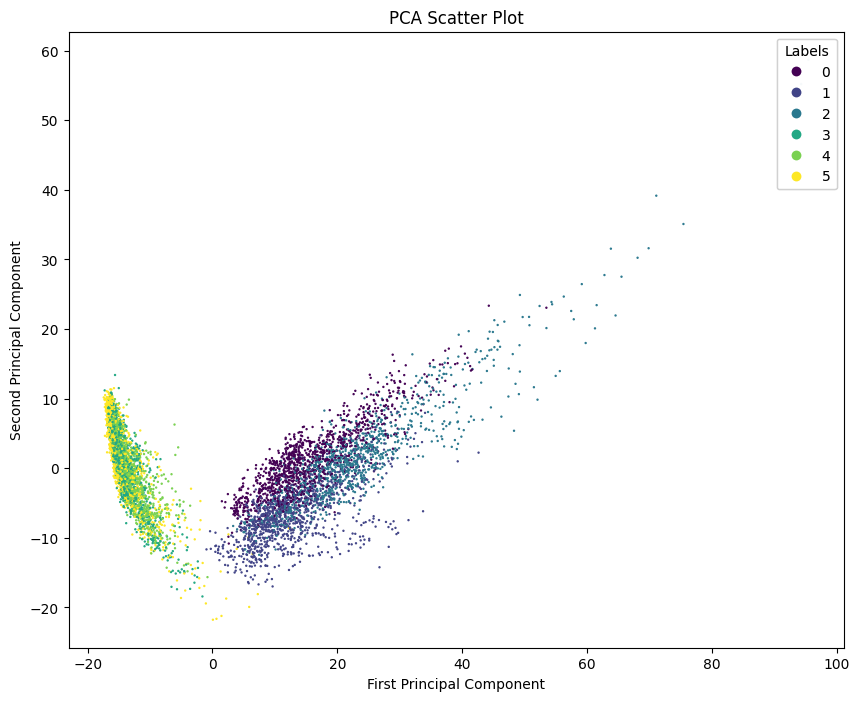

In [10]:

from MakeHARDataset import load_har_data

# Load data
X_train, y_train, X_test, y_test = load_har_data()
# Plot PCA directly
plot_pca(X_train, y_train, 2)


## Comparing PCA results
We can see that the classes are easily seperable in the PCA on the TSFEL features and the UCI HAR dataset features compared to the PCA on the total acceleration. This suggests that we might get better results using the TSFEL features and UCI HAR in a decision tree, better than the raw data. However it might be a bit difficult to see which set of features will perform better on decision tree, since the number of features are reduced by a large number. However we can see that the dynamic activities are scattered all over the place in the linear acceleration PCA and the static activities are more or less clustered together. This suggests that the TSFEL and UCI HAR dataset features might perform better in a decision tree.

## 4. Correlation between TSFEL features and UCI HAR dataset features.
Let A, B, C be features of our dataset. If A and B are correlated with each other (+vely or -vely) and B and C are correlated with each other, then A and C are also correlated with each other. Hence it will be redundant to use all 3: A, B and C in our model. Hence, we make cluster of highly correlated features and then choose one random feature from each cluster. We consider 2 variables to be highly correlated if the correlation coefficient is greater than $1 - \epsilon \ \text{where} \ \epsilon = 10^{-1}$. 

This is because if we have 3 highly correlated features: A, B and C, then we will get the same data seperation if we split our data based on A or B or C. During the training process of the Decision tree. Hence, we can choose any one of them.

In [11]:


import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random

def load_tsfel_split(base_dir, split="Train"):
    """
    Reads all activity CSV files from tsfel_3axes/<split> into one DataFrame
    """
    split_path = os.path.join(base_dir, split)
    all_data = []

    for activity in os.listdir(split_path):
        activity_path = os.path.join(split_path, activity)
        if os.path.isdir(activity_path):
            for file in os.listdir(activity_path):
                if file.endswith(".csv"):
                    file_path = os.path.join(activity_path, file)
                    try:
                        df = pd.read_csv(file_path)
                        df["activity"] = activity   # keep activity label
                        all_data.append(df)
                    except Exception as e:
                        print(f"[ERROR] {file_path}: {e}")

    return pd.concat(all_data, ignore_index=True)

def get_correlation_data(x, threshold=0.9):
    # Remove constant features
    redundant_features = []
    for feature in x.columns:
        if x[feature].std() == 0:
            redundant_features.append(feature)
    x = x.drop(columns=redundant_features)
    
    print(f"Removed {len(redundant_features)} constant features")

    # Compute correlation matrix
    corr = x.corr()
    # Extract correlations
    correlations = []
    for i in range(len(corr.columns)):
        for j in range(i + 1, len(corr.columns)):
            feature1 = corr.columns[i]
            feature2 = corr.columns[j]
            value = corr.iloc[i, j]
            if not np.isnan(value):
                correlations.append([value, [feature1, feature2]])

    correlations.sort(key=lambda x: abs(x[0]), reverse=True)
    return correlations, corr


def display_correlation_matrix_and_highly_correlated_features(x, top_n=20):
    correlations, corr_mat = get_correlation_data(x)

    df = pd.DataFrame({
        'Correlation coefficient': [c[0] for c in correlations],
        'Feature 1': [c[1][0] for c in correlations],
        'Feature 2': [c[1][1] for c in correlations]
    })

    print("\nTop Highly Positively Correlated Features:")
    display(df[df['Correlation coefficient'] > 0].head(top_n))

    print("\nTop Highly Negatively Correlated Features:")
    display(df[df['Correlation coefficient'] < 0].head(top_n))

    print("\nCorrelation Matrix:")
    display(corr_mat)

    return corr_mat, df


def cluster_correlated_data(x, eps=0.05):
    correlations, _ = get_correlation_data(x)
    correlated_clusters = {}
    cluster_id = {}
    next_id = 0
    for corr, features in correlations:
        if abs(corr) >= 1 - eps:
            if features[0] in cluster_id and features[1] in cluster_id:
                id1, id2 = cluster_id[features[0]], cluster_id[features[1]]
                if id1 != id2:
                    correlated_clusters[id1] += correlated_clusters[id2]
                    for f in correlated_clusters[id2]:
                        cluster_id[f] = id1
                    del correlated_clusters[id2]
            elif features[0] in cluster_id:
                correlated_clusters[cluster_id[features[0]]].append(features[1])
                cluster_id[features[1]] = cluster_id[features[0]]
            elif features[1] in cluster_id:
                correlated_clusters[cluster_id[features[1]]].append(features[0])
                cluster_id[features[0]] = cluster_id[features[1]]
            else:
                correlated_clusters[next_id]=[features[0], features[1]]
                cluster_id[features[0]] =cluster_id[features[1]] = next_id
                next_id += 1

    print("Number of correlated feature clusters:", len(correlated_clusters))
    feature_list = [random.choice(correlated_clusters[idx]) for idx in correlated_clusters]
    return feature_list


# def plot_heatmap(data):
#     plt.figure(figsize=(12, 8))
#     sns.heatmap(data.corr(), cmap="YlGnBu", annot=False)
#     plt.title("Feature Correlation Heatmap")
#     plt.show()

BASE_DIR = "Datasets\TSFEL_3axes_allfeatures"
data = load_tsfel_split(BASE_DIR, split="Train")
# Drop "activity" column for correlation analysis
X_train_tsfel = data.drop(columns=["activity"])
# Run correlation analysis
corr_mat, df = display_correlation_matrix_and_highly_correlated_features(X_train_tsfel)
# Cluster redundant features
useful_features = cluster_correlated_data(X_train_tsfel, eps=0.1)





Removed 12 constant features

Top Highly Positively Correlated Features:


,Correlation coefficient,Feature 1,Feature 2
0,1.0,accx_Spectral centroid,accx_Spectral slope
1,1.0,accy_Absolute energy,accy_Average power
2,1.0,accy_Spectral centroid,accy_Spectral slope
3,1.0,accz_Mean absolute diff,accz_Sum absolute diff
4,1.0,accx_LPCC_5,accx_LPCC_7
5,1.0,accx_Mean absolute diff,accx_Sum absolute diff
6,1.0,accy_LPCC_10,accy_LPCC_2
7,1.0,accy_LPCC_5,accy_LPCC_7
8,1.0,accx_LPCC_1,accx_LPCC_11
9,1.0,accx_LPCC_10,accx_LPCC_2



Top Highly Negatively Correlated Features:


,Correlation coefficient,Feature 1,Feature 2
213,-0.990582,accx_Max,accx_Spectral distance
245,-0.987831,accx_Spectral decrease,accx_Spectral kurtosis
335,-0.981922,accy_Spectral decrease,accy_Spectral kurtosis
344,-0.980524,accz_Spectral decrease,accz_Spectral kurtosis
350,-0.979899,accz_Maximum frequency,accz_Spectral skewness
351,-0.979899,accz_Spectral roll-off,accz_Spectral skewness
575,-0.963787,accx_Spectral decrease,accx_Spectral skewness
648,-0.960515,accy_Maximum frequency,accy_Spectral skewness
649,-0.960515,accy_Spectral roll-off,accy_Spectral skewness
681,-0.959129,accz_Spectral skewness,accz_Spectral spread



Correlation Matrix:


,accx_Absolute energy,accx_Area under the curve,accx_Autocorrelation,accx_Average power,accx_Centroid,accx_Detrended fluctuation analysis,accx_ECDF Percentile_0,accx_ECDF Percentile_1,accx_ECDF_0,accx_ECDF_1,...,accz_Wavelet variance_1.39Hz,accz_Wavelet variance_1.56Hz,accz_Wavelet variance_1.79Hz,accz_Wavelet variance_12.5Hz,accz_Wavelet variance_2.08Hz,accz_Wavelet variance_2.5Hz,accz_Wavelet variance_3.12Hz,accz_Wavelet variance_4.17Hz,accz_Wavelet variance_6.25Hz,accz_Zero crossing rate
accx_Absolute energy,1.000000,0.980108,-0.269922,1.000000,0.257370,0.282594,0.853889,0.973178,NaN,NaN,...,0.185216,0.207720,0.224269,0.348573,0.238943,0.256871,0.283139,0.318650,0.339828,0.485104
accx_Area under the curve,0.980108,1.000000,-0.226415,0.980108,0.273590,0.209675,0.919913,0.951653,NaN,NaN,...,0.165653,0.187604,0.202296,0.276829,0.213199,0.224568,0.240335,0.262614,0.275563,0.380451
accx_Autocorrelation,-0.269922,-0.226415,1.000000,-0.269922,-0.465086,0.023634,-0.238159,-0.258918,NaN,NaN,...,-0.155827,-0.165133,-0.170198,-0.186771,-0.174057,-0.178877,-0.184876,-0.190971,-0.188193,-0.206092
accx_Average power,1.000000,0.980108,-0.269922,1.000000,0.257370,0.282594,0.853889,0.973178,NaN,NaN,...,0.185216,0.207720,0.224269,0.348573,0.238943,0.256871,0.283139,0.318650,0.339828,0.485104
accx_Centroid,0.257370,0.273590,-0.465086,0.257370,1.000000,0.011586,0.311401,0.262041,NaN,NaN,...,0.085744,0.089120,0.090409,0.088965,0.091453,0.093601,0.096332,0.096873,0.091618,0.090010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
accz_Wavelet variance_2.5Hz,0.256871,0.224568,-0.178877,0.256871,0.093601,0.490507,0.020609,0.358103,NaN,NaN,...,0.869320,0.940036,0.975752,0.649417,0.992738,1.000000,0.982518,0.903974,0.749564,0.206677
accz_Wavelet variance_3.12Hz,0.283139,0.240335,-0.184876,0.283139,0.096332,0.488005,0.025393,0.381634,NaN,NaN,...,0.811359,0.885380,0.927118,0.730258,0.954856,0.982518,1.000000,0.963715,0.830033,0.272442
accz_Wavelet variance_4.17Hz,0.318650,0.262614,-0.190971,0.318650,0.096873,0.466134,0.040523,0.409636,NaN,NaN,...,0.702254,0.774392,0.819128,0.846800,0.855917,0.903974,0.963715,1.000000,0.936902,0.394415
accz_Wavelet variance_6.25Hz,0.339828,0.275563,-0.188193,0.339828,0.091618,0.412272,0.064554,0.418091,NaN,NaN,...,0.535901,0.606836,0.654494,0.952948,0.695331,0.749564,0.830033,0.936902,1.000000,0.523594


Removed 12 constant features
Number of correlated feature clusters: 20
